In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier()
import interpret
print(interpret.__version__)
import sys
print(sys.version_info)
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import f1_score
import os

from interpret import show
from interpret.visual.interactive import get_show_addr, set_show_addr
set_show_addr(("127.0.0.1", 8889))

from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

from ContextualGAM import ContextualGAM
from plot_utils import *

0.2.7
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


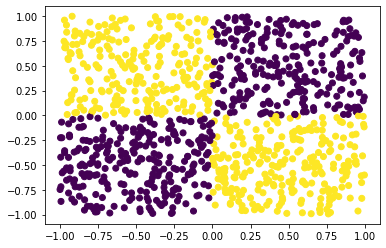

In [2]:
X = np.random.uniform(-1, 1, size=(1000, 2))
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], c=Y)

col_names = [i for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=col_names)
Y = pd.DataFrame(Y).astype(np.int)
# Model can handle either regression or classification, but plotting currently implemented for classification.

In [3]:
contextual_feats = col_names
explainable_feats = []
for feat in contextual_feats:
    explainable_name = "{} Elev.".format(feat)
    X[explainable_name] = X[feat] > 0. #np.percentile(X[feat], 50)#0.
    X[explainable_name] = X[explainable_name].astype(np.int)
    explainable_feats.append(explainable_name)

contextual = X[contextual_feats].copy()
explainable = X[explainable_feats].copy()

C_train, C_test, X_train, X_test, X_all_train, X_all_test, Y_train, Y_test = train_test_split(
    contextual, explainable, X, Y, test_size=0.25)

In [4]:
# Fit a global additive model as background.
# Additive models can't model interactions, so this should be a terrible fit.
ebm_all = ExplainableBoostingClassifier(
    interactions=0,
    outer_bags=5,
    inner_bags=1,
    min_samples_leaf=25,
    validation_size=0.2,
    early_stopping_rounds=25,
    max_bins=32)
ebm_all.fit(X_all_train, Y_train)
print(roc(Y_test,  ebm_all.predict_proba(X_all_test)[:, 1]))
print(f1_score(Y_test, ebm_all.predict(X_all_test)))

0.5655847897061648
0.4953271028037384


In [5]:
# Fit Contextualized GAMs.
# We bootstrap these to get confidence intervals.

archetype_init = np.eye(X_train.shape[1])
k = X_train.shape[1]
make_cgam = lambda : ContextualGAM(
    encoder_input_shape=(contextual.shape[1]),
    encoder_output_shape=(k, ),
    encoder_depth=2,
    encoder_width=8, # reduce?
    activation='sigmoid',
    contextual_bools=None,#contextual_bools,
    dict_shape=(k, explainable.shape[1]),
    X_shape=(explainable.shape[1]),
    sample_specific_loss_params={'l1': 0.},
    archetype_loss_params={'l1': 0.},
    archetype_init=archetype_init,
    learning_rate=1e-3,
    use_skip=True, 
    base_model=ebm_all,
    skip_encoder_depth=2,
    skip_encoder_width=8,
    skip_activation='sigmoid'
)

cgams = []
for iteration in range(5):
    cgam = make_cgam()
    idx_train_train, idx_train_val = train_test_split(range(len(C_train)), test_size=0.3)
    epoch, train_auc, val_auc = cgam.fit(
        C_train.iloc[idx_train_train],
        X_train.iloc[idx_train_train],
        Y_train.iloc[idx_train_train],
        X_all_train.iloc[idx_train_train],
        verbose=0, batch_size=1, early_stopping_epochs=10)
    print("{}, {}, {:.4f}, {:.4f}".format(iteration, epoch, train_auc, val_auc))
    cgams.append(cgam)

0, 13, 0.9944, 1.0000
1, 11, 0.9782, 1.0000
2, 25, 1.0000, 1.0000
3, 30, 1.0000, 1.0000
4, 15, 0.9996, 1.0000


In [6]:
cgams = []
for iteration in range(5):
    cgam = make_cgam()
    idx_train_train, idx_train_val = train_test_split(range(len(C_train)), test_size=0.3)
    epoch, train_auc, val_auc = cgam.fit(
        C_train.iloc[idx_train_train],
        X_train.iloc[idx_train_train],
        Y_train.iloc[idx_train_train],
        X_all_train.iloc[idx_train_train],
        verbose=0, batch_size=1, early_stopping_epochs=10)
    print("{}, {}, {:.4f}, {:.4f}".format(iteration, epoch, train_auc, val_auc))
    cgams.append(cgam)

0, 28, 0.9990, 1.0000
1, 25, 0.9996, 1.0000
2, 20, 1.0000, 1.0000
3, 17, 0.9933, 1.0000
4, 9, 0.9984, 1.0000


In [7]:
train_preds = np.mean([cgam.predict_proba(C_train.values.astype(np.float32),
                                          X_train.values.astype(np.float32),
                                          X_all_train.values.astype(np.float32)) for cgam in cgams], axis=0)
test_preds  = np.mean([cgam.predict_proba(C_test.values.astype(np.float32),
                                          X_test.values.astype(np.float32),
                                          X_all_test.values.astype(np.float32)) for cgam in cgams], axis=0)
results = {
        "cgam": {
            "train": {
                "roc": roc(Y_train, train_preds),
                "f1": f1_score(Y_train, np.round(train_preds))
            },
            "test": {
                "roc": roc(Y_test, test_preds),
                "f1": f1_score(Y_test, np.round(test_preds))
            }}}
print(results)

{'cgam': {'train': {'roc': 0.9997007182761373, 'f1': 0.9887640449438202}, 'test': {'roc': 0.9992958197298508, 'f1': 0.9841269841269842}}}


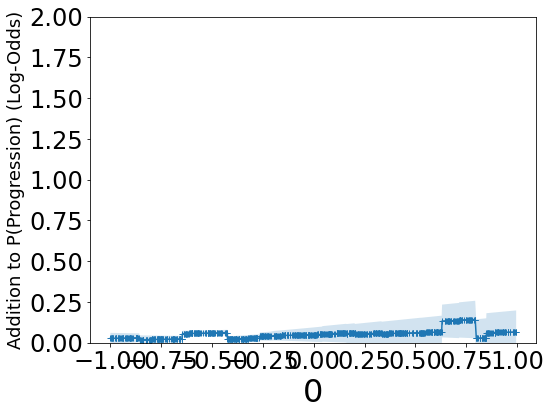

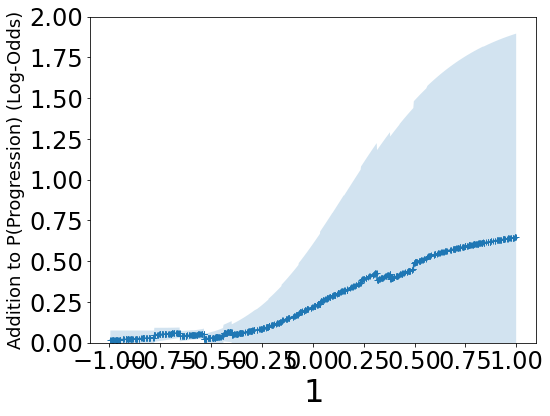

In [8]:
# Plot Homogeneous (Background effects).
# In this example of XOR interaction, these effects should be 0.
plot_cgams_homogeneous_effects(cgams, C_train, X_all_train)

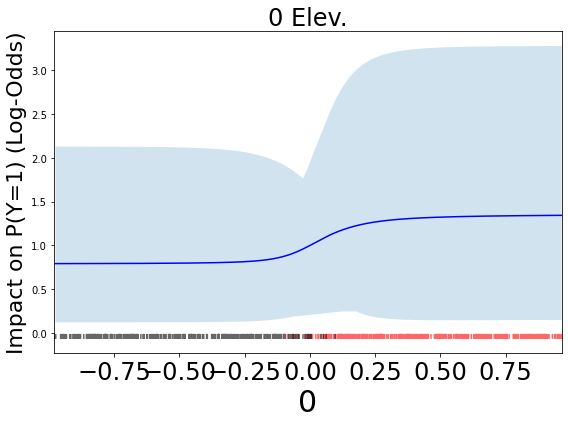

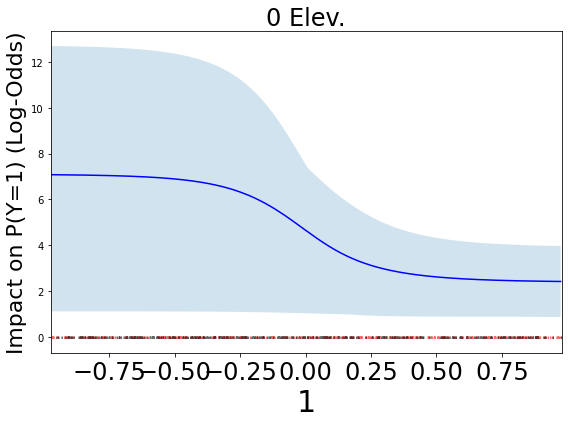

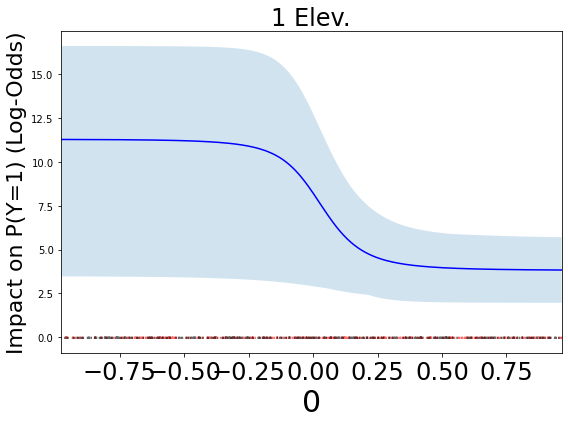

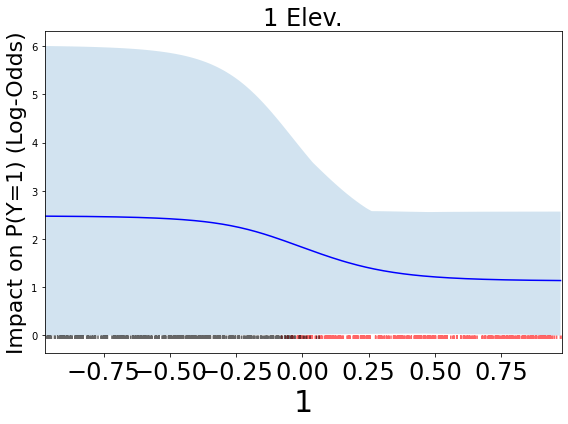

In [9]:
# Plot Heterogeneous (Interactive effects).
# In this example of XOR interaction, the cross-effects (1->0 Elevated) and (0->1 Elevated) are strong.
plot_cgams_heterogeneous(cgams, C_train, X_train)